# Dodo Trail 2025 
## 10km Race
### Race Results Data Exploration & Analysis

### Outline

1. **Empirical CDF with Percentile Rank**
_Show where I sit in the overall distribution of finish times._

2. **Pace Distribution Histogram**
_Convert finish times to pace (min/km) and show the distribution, highlighting my pace._

3. **Performance Clustering via K-Means**
_Group runners into performance tiers and see which tier I fall into._



In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
from lxml import html
import matplotlib.pyplot as plt
import numpy as np

In [2]:
raw_data = []

## 1. Webscraping and Retrieving Race Results Data

In [3]:
# 1. Fetch the page
print("Scraping started...")
for pageNumber in range(1, 27):

    print(f"Scraping page {pageNumber}")
    resp = requests.get(f"https://results.finishtime.co.za/results.aspx?CId=35&RId=5248&EId=2&dt=0&PageNo={pageNumber}")
    resp.raise_for_status()

    # 2. Parse into an lxml element tree
    tree = html.fromstring(resp.content)

    # 3. Locate your table
    table_xpath = '//*[@id="ctl00_Content_Main_divGrid"]/table'
    table = tree.xpath(table_xpath)[0]

    # 4. Iterate over rows
    for idx, row in enumerate(table.xpath(".//tr")):
        # skip header
        if idx == 0:
            continue

        values = []
        for cell in row.xpath(".//td"):
            # try to pull anchor text
            anchor_texts = cell.xpath(".//a/text()")
            if anchor_texts:
                values.append(anchor_texts[0].strip())
            else:
                # string(.) collapses all text descendants
                values.append(cell.xpath("string(.)").strip())

        raw_data.append([values[1], values[2], values[5], values[7], values[8], values[9], values[11], values[12], values[13], values[14], values[15], values[17]])
print("Scraping done...")

Scraping started...
Scraping page 1
Scraping page 2
Scraping page 3
Scraping page 4
Scraping page 5
Scraping page 6
Scraping page 7
Scraping page 8
Scraping page 9
Scraping page 10
Scraping page 11
Scraping page 12
Scraping page 13
Scraping page 14
Scraping page 15
Scraping page 16
Scraping page 17
Scraping page 18
Scraping page 19
Scraping page 20
Scraping page 21
Scraping page 22
Scraping page 23
Scraping page 24
Scraping page 25
Scraping page 26
Scraping done...


In [4]:
columns = ['Race No', 'Pos', 'Name', 'Time', 'Pace', 'Overall Pos', 'Category', 'Cat Pos', 'Gender', 'Gen Pos', 'Country', 'Finish']

In [5]:
df = pd.DataFrame(raw_data, columns=columns)

### Peeking into data

In [6]:
df.head(5)

,Race No,Pos,Name,Time,Pace,Overall Pos,Category,Cat Pos,Gender,Gen Pos,Country,Finish
0,1200,1,Badal DUSOOA,00:52:16,5:13 min/km,1,20-39,1,Male,1,Mauritius,00:52:16
1,1091,2,Hanooveer Singh BOODHOA,00:53:07,5:18 min/km,2,20-39,2,Male,2,Mauritius,00:53:07
2,1152,3,Calvin Roy CUROOPEN,00:53:50,5:23 min/km,3,20-39,3,Male,3,Mauritius,00:53:50
3,1306,4,Nilesh ITTOO,00:54:28,5:26 min/km,4,20-39,4,Male,4,Mauritius,00:54:28
4,1280,5,Reane Bradley HINGOO,00:55:15,5:31 min/km,5,16-17,1,Male,5,Mauritius,00:55:15


In [7]:
my_name = 'Kherin BUNDHOO'

In [10]:
len(df)

1292

In [11]:
df[df['Name'] == my_name]

,Race No,Pos,Name,Time,Pace,Overall Pos,Category,Cat Pos,Gender,Gen Pos,Country,Finish
80,1102,81,Kherin BUNDHOO,01:14:25,7:26 min/km,81,20-39,37,Male,72,Mauritius,01:14:25


## A. **Empirical CDF with Percentile Rank** 
- Show where I sit in the overall distribution of finish times.

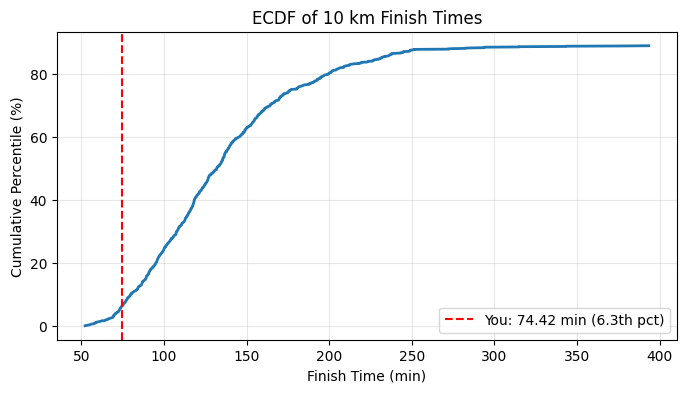

In [12]:
# 1. Parse times and compute seconds
df['NetTime'] = pd.to_timedelta(df['Finish'])
df['Time_sec'] = df['NetTime'].dt.total_seconds()

# 2. Extract your time
my_time = df.loc[df['Name'] == my_name, 'Time_sec'].iloc[0]

# 3. Build ECDF
times_sorted = np.sort(df['Time_sec'])
ecdf = np.arange(1, len(times_sorted)+1) / len(times_sorted)

# 4. Plot
plt.figure(figsize=(8, 4))
plt.plot(times_sorted/60, ecdf*100, lw=2)
plt.axvline(my_time/60, color='red', linestyle='--',
            label=f'You: {my_time/60:.2f} min ({ecdf[times_sorted <= my_time].max()*100:.1f}th pct)')
plt.xlabel('Finish Time (min)')
plt.ylabel('Cumulative Percentile (%)')
plt.title('ECDF of 10 km Finish Times')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## B. **Pace Distribution Histogram**
- Convert finish times to pace (min/km) and show the distribution, highlighting your pace

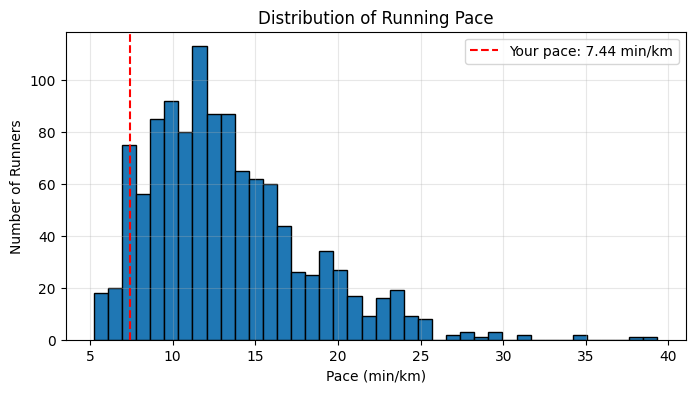

In [13]:
# 1. Compute pace (seconds per km, then minutes)
df['Pace_sec_per_km'] = df['Time_sec'] / 10
df['Pace_min_per_km'] = df['Pace_sec_per_km'] / 60

# 2. Your pace
my_pace = df.loc[df['Name'] == my_name, 'Pace_min_per_km'].iloc[0]

# 3. Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(df['Pace_min_per_km'], bins=40, edgecolor='black')
plt.axvline(my_pace, color='red', linestyle='--',
            label=f'Your pace: {my_pace:.2f} min/km')
plt.xlabel('Pace (min/km)')
plt.ylabel('Number of Runners')
plt.title('Distribution of Running Pace')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## C. **Performance Clustering via K-Means**

In [14]:
from sklearn.cluster import KMeans

# 1. Assign rank and prepare clustering
# Filtering for na values
df = df[df['Time_sec'].notna()]
df['Time_sec'].isna().any()
df['Rank'] = df['Time_sec'].rank(method='min', ascending=True).astype(int)
X = df[['Time_sec']]


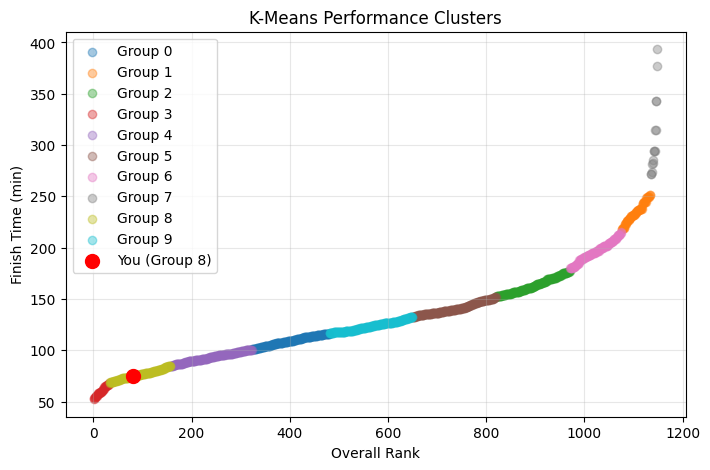

In [15]:
# 2. Cluster into, say, 4 groups
kmeans = KMeans(n_clusters=10, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# 3. Find your cluster & rank
my_cluster = df.loc[df['Name'] == my_name, 'Cluster'].iloc[0]
my_rank = df.loc[df['Name'] == my_name, 'Rank'].iloc[0]

# 4. Scatter plot: Rank vs Time, colored by cluster
plt.figure(figsize=(8, 5))
for cluster in sorted(df['Cluster'].unique()):
    grp = df[df['Cluster'] == cluster]
    plt.scatter(grp['Rank'], grp['Time_sec']/60, alpha=0.4, label=f'Group {cluster}')
    
plt.scatter(my_rank, my_time/60, color='red', s=100,
            label=f'You (Group {my_cluster})')
plt.xlabel('Overall Rank')
plt.ylabel('Finish Time (min)')
plt.title('K-Means Performance Clusters')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
